<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">MNIST: CNN</h1>
</div>

Problem Type: Multi-classification

## Evaluation Metric

In [1]:
# Black formatter https://black.readthedocs.io/en/stable/

! pip install nb-black > /dev/null

%load_ext lab_black

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Configuration</h1>
</div>

In [2]:
data_dir = "../input/digit-recognizer"

In [3]:
TARGET = "label"

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Import Libraries</h1>
</div>

A best practise is to include all libraries here.  However, I will put a few imports farther down where they are first used so beginners can learn with an "as needed" approach.

In [4]:
import os
import time
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

# Visualization Libraries
import matplotlib.pylab as plt
import seaborn as sns

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Library</h1>
</div>

Creating a few functions that we will reuse in each project.

In [5]:
def read_data(path):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    print(f"train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
    print(f"test data : Rows={test.shape[0]}, Columns={test.shape[1]}")
    return train, test, submission_df

In [6]:
def create_submission(model_name, target, preds, is_log_target=False):
    if is_log_target:
        #         preds = np.exp(preds)
        preds = np.expm1(preds)

    sample_submission[target] = preds
    if len(model_name) > 0:
        sample_submission.to_csv(f"submission_{model_name}.csv", index=False)
    else:
        sample_submission.to_csv(f"submission.csv", index=False)

    return sample_submission[:5]

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score


def show_scores(gt, yhat):
    f1 = f1_score(gt, yhat, average="macro")
    mse = mean_squared_error(gt, yhat)
    mae = mean_absolute_error(gt, yhat)
    rmse = np.sqrt(mse)
    #     r2_square = r2_score(gt, yhat)

    print(f"f1: {f1:.4f}")

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Load Train/Test Data</h1>
</div>

- train.csv - Data used to build our machine learning model
- test.csv - Data used to build our machine learning model. Does not contain the target variable
- sample_submission.csv - A file in the proper format to submit test predictions

In [8]:
train, test, sample_submission = read_data(data_dir)

train data: Rows=42000, Columns=785
test data : Rows=28000, Columns=784


In [9]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
FEATURES = [
    col
    for col in train.columns
    if col
    not in [
        "Id",
        TARGET,
        #         TARGET_ENC,
    ]
]

In [11]:
y = train[TARGET]
X = train[FEATURES].copy()

X_test = test[FEATURES].copy()

In [12]:
# Normalize the data
X = X / 255.0
X_test = X_test / 255.0

In [13]:
X = X.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

In [14]:
# X[:3]

In [15]:
from keras.utils.np_utils import to_categorical

y = to_categorical(y)

In [16]:
y[:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((33600, 28, 28, 1), (33600, 10), (8400, 28, 28, 1), (8400, 10))

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Create Models</h1>
</div>

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


def get_tf_model01(x_shape):
    print(f"x_shape=")
    #     input_shape = (height, width, channels)
    inputs = keras.Input(shape=(28, 28, 1))

    x = keras.layers.Conv2D(
        64,
        kernel_size=3,
        activation="relu",
        padding="same",
        input_shape=(28, 28, 1),
        kernel_initializer="he_normal",
    )(inputs)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(
        64,
        kernel_size=3,
        activation="relu",
        padding="same",
        kernel_initializer="he_normal",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    #     x = keras.layers.MaxPooling2d((2, 2))(x)
    #     x = keras.layers.Conv2D(
    #         128, activation="relu", padding="same", kernel_initializer="he_normal"
    #     )(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.BatchNormalization()(x)

    #     x = keras.layers.Dense(128, activation="relu")(x)

    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    #     x = keras.layers.Dropout(0.1)(x)

    outputs = keras.layers.Dense(10, activation="softmax")(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # rmsprop
        metrics=["accuracy"],
    )

    #     model.compile(
    #         optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    #         loss="mean_absolute_error",
    #     )

    return model

In [19]:
def get_tf_model02(x_shape):
    print(f"x_shape=")
    #     input_shape = (height, width, channels)
    inputs = keras.Input(shape=(28, 28, 1))

    x = Conv2D(
        32, (5, 5), strides=1, padding="same", input_shape=(28, 28, 1), name="conv1"
    )(inputs)
    x = BatchNormalization(
        momentum=0.1, epsilon=1e-5, gamma_initializer="uniform", name="batch1"
    )(x)
    x = Activation("relu", name="relu1")(x)
    # x = Dropout (0.5)(x)
    x = Conv2D(32, (5, 5), strides=1, padding="same", name="conv2")(x)
    x = BatchNormalization(
        momentum=0.1, epsilon=1e-5, gamma_initializer="uniform", name="batch2"
    )(x)
    x = Activation("relu", name="relu2")(x)
    # x = Dropout (0.5)(x)
    x = Conv2D(32, (5, 5), strides=1, padding="same", name="conv2add")(x)
    x = BatchNormalization(
        momentum=0.1, epsilon=1e-5, gamma_initializer="uniform", name="batch2add"
    )(x)
    x = Activation("relu", name="relu2add")(x)
    x = Dropout(0.15)(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), strides=1, padding="same", name="conv3")(x)
    x = BatchNormalization(
        momentum=0.1, epsilon=1e-5, gamma_initializer="uniform", name="batch3"
    )(x)
    x = Activation("relu", name="relu3")(x)
    x = Conv2D(64, (3, 3), strides=1, padding="same", name="conv4")(x)
    x = BatchNormalization(
        momentum=0.1, epsilon=1e-5, gamma_initializer="uniform", name="batch4"
    )(x)
    x = Activation("relu", name="relu4")(x)
    x = Conv2D(32, (3, 3), strides=1, padding="same", name="conv5")(x)
    x = BatchNormalization(
        momentum=0.1, epsilon=1e-5, gamma_initializer="uniform", name="batch5"
    )(x)
    x = Activation("relu", name="relu5")(x)
    x = Dropout(0.15)(x)
    x = keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)
    x = keras.layers.Flatten()(x)

    x = Dense(100, name="Dense30")(x)
    x = Activation("relu", name="relu6")(x)
    x = Dropout(0.05)(x)
    x = Dense(10, name="Dense10")(x)
    outputs = Activation("softmax")(x)

    #     x = keras.layers.BatchNormalization()(x)

    #     x = keras.layers.Dense(64, activation="relu")(x)
    #     x = keras.layers.BatchNormalization()(x)
    #     x = keras.layers.Dense(32, activation="relu")(x)
    #     x = keras.layers.BatchNormalization()(x)
    #     #     x = keras.layers.Dropout(0.1)(x)

    #     outputs = keras.layers.Dense(10, activation="softmax")(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # rmsprop
        metrics=["accuracy"],
    )

    #     model.compile(
    #         optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    #         loss="mean_absolute_error",
    #     )

    return model

- https://www.kaggle.com/code/shaygu/fast-cnn-for-beginners-0-9955?scriptVersionId=19400310
- Light architecture with approximately 50K parameters. 
- Dropout for avoiding overfitting 
- BatchNormalization for faster convergence time

In [20]:
from tensorflow.keras.layers import (
    Input,
    Dense,
    Conv2D,
    Activation,
    Add,
    ReLU,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.models import Model


def get_model02():
    inputs = keras.Input(shape=(28, 28, 1))

    #     input = Input(shape=[28, 28, 1])
    x = Conv2D(
        32, (5, 5), strides=1, padding="same", input_shape=(28, 28, 1), name="conv1"
    )(inputs)
    x = BatchNormalization(
        momentum=0.1, epsilon=1e-5, gamma_initializer="uniform", name="batch1"
    )(x)
    x = Activation("relu", name="relu1")(x)
    # x = Dropout (0.5)(x)
    x = Conv2D(32, (5, 5), strides=1, padding="same", name="conv2")(x)
    x = BatchNormalization(
        momentum=0.1, epsilon=1e-5, gamma_initializer="uniform", name="batch2"
    )(x)
    x = Activation("relu", name="relu2")(x)
    # x = Dropout (0.5)(x)
    x = Conv2D(32, (5, 5), strides=1, padding="same", name="conv2add")(x)
    x = BatchNormalization(
        momentum=0.1, epsilon=1e-5, gamma_initializer="uniform", name="batch2add"
    )(x)
    x = Activation("relu", name="relu2add")(x)
    x = Dropout(0.15)(x)
    x = MaxPool2D(pool_size=2, strides=2, padding="same")(x)

    # ---
    x = Conv2D(64, (3, 3), strides=1, padding="same", name="conv3")(x)
    x = BatchNormalization(
        momentum=0.1, epsilon=1e-5, gamma_initializer="uniform", name="batch3"
    )(x)
    x = Activation("relu", name="relu3")(x)
    x = Conv2D(64, (3, 3), strides=1, padding="same", name="conv4")(x)
    x = BatchNormalization(
        momentum=0.1, epsilon=1e-5, gamma_initializer="uniform", name="batch4"
    )(x)
    x = Activation("relu", name="relu4")(x)
    x = Conv2D(32, (3, 3), strides=1, padding="same", name="conv5")(x)
    x = BatchNormalization(
        momentum=0.1, epsilon=1e-5, gamma_initializer="uniform", name="batch5"
    )(x)
    x = Activation("relu", name="relu5")(x)
    x = Dropout(0.15)(x)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = Flatten()(x)
    x = Dense(100, name="Dense30")(x)
    x = Activation("relu", name="relu6")(x)
    x = Dropout(0.05)(x)
    x = Dense(10, name="Dense10")(x)
    x = Activation("softmax")(x)
    model = Model(inputs=inputs, outputs=x)
    return model

In [21]:
X_train.shape[1]

28

In [22]:
X.shape[0]

42000

In [23]:
model = get_tf_model02(x_shape=(28, 28))
# model = get_model02()

model.summary()

x_shape=


2022-07-25 01:21:18.529687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
batch1 (BatchNormalization)  (None, 28, 28, 32)        128       
_________________________________________________________________
relu1 (Activation)           (None, 28, 28, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 32)        25632     
_________________________________________________________________
batch2 (BatchNormalization)  (None, 28, 28, 32)        128       
_________________________________________________________________
relu2 (Activation)           (None, 28, 28, 32)        0     

2022-07-25 01:21:18.671232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 01:21:18.672062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 01:21:18.674353: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-25 01:21:18.674679: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

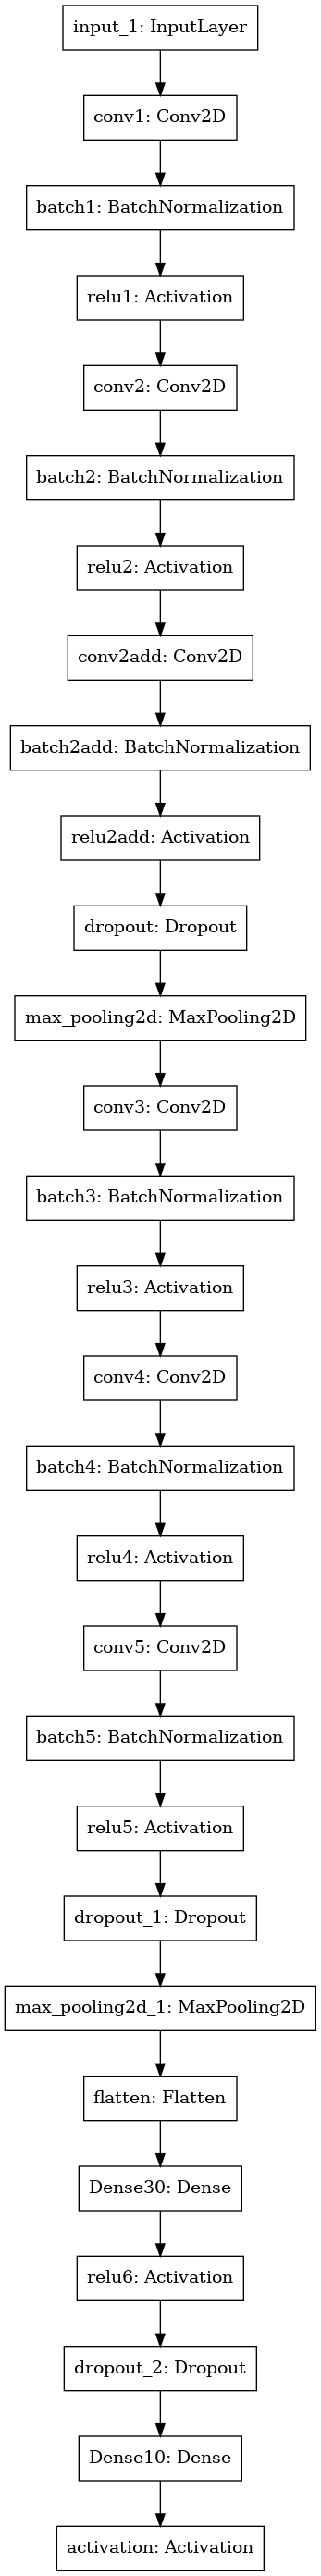

In [24]:
keras.utils.plot_model(model)

In [25]:
%%time

epochs = 60
lr_initial = 0.0011
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.95, epsilon=1e-08, decay=0.0)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_initial, 
#                                      decay=lr_initial / (epochs*1.3))
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)  # rmsprop

# model.compile(optimizer=optimizer,
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
# datagen.fit(x_train)
batch_size = 64

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    # Suppress logging.
    verbose=1,
    validation_data=(X_valid, y_valid),
    # Calculate validation results on 20% of the training data.
#     validation_split = 0.2
)

2022-07-25 01:21:22.752823: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-07-25 01:21:24.513192: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


525/525 [==============================] - 12s 9ms/step - loss: 0.2012 - accuracy: 0.9342 - val_loss: 0.1100 - val_accuracy: 0.9683
Epoch 2/60
525/525 [==============================] - 4s 8ms/step - loss: 0.0779 - accuracy: 0.9765 - val_loss: 0.0610 - val_accuracy: 0.9830
Epoch 3/60
525/525 [==============================] - 4s 8ms/step - loss: 0.0629 - accuracy: 0.9803 - val_loss: 0.0636 - val_accuracy: 0.9813
Epoch 4/60
525/525 [==============================] - 4s 8ms/step - loss: 0.0534 - accuracy: 0.9838 - val_loss: 0.0693 - val_accuracy: 0.9792
Epoch 5/60
525/525 [==============================] - 5s 9ms/step - loss: 0.0492 - accuracy: 0.9852 - val_loss: 0.0545 - val_accuracy: 0.9836
Epoch 6/60
525/525 [==============================] - 4s 8ms/step - loss: 0.0443 - accuracy: 0.9866 - val_loss: 0.0619 - val_accuracy: 0.9838
Epoch 7/60
525/525 [==============================] - 4s 8ms/step - loss: 0.0468 - accuracy: 0.9860 - val_loss: 0.0478 - val_accuracy: 0.9852
Epoch 8/60
525/5

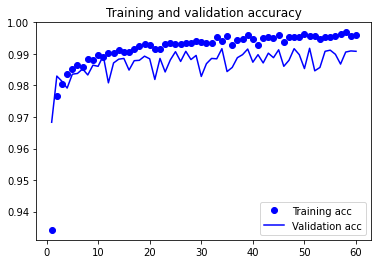

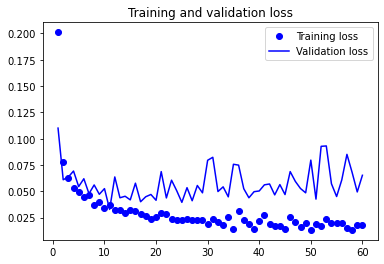

In [26]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

## Predict and Score

In [27]:
test_loss, test_acc = model.evaluate(X_valid, y_valid)
test_acc

263/263 [==============================] - 1s 3ms/step - loss: 0.0652 - accuracy: 0.9908


0.9908333420753479

In [28]:
valid_preds = model.predict(X_valid)
valid_preds[:5]

array([[1.66118211e-24, 4.86952729e-29, 2.86165476e-21, 9.08709229e-24,
        3.34947382e-26, 6.42368993e-23, 1.05272918e-26, 2.00190292e-25,
        1.00000000e+00, 2.28326283e-26],
       [1.31826852e-27, 1.00000000e+00, 1.56934310e-22, 1.56677498e-32,
        2.13238498e-21, 3.54023735e-24, 4.30978102e-24, 6.31037349e-20,
        9.75044574e-23, 2.39464817e-25],
       [8.46735607e-24, 1.04784926e-26, 8.80275844e-28, 4.35543460e-22,
        2.67283466e-14, 7.60277159e-19, 1.01535262e-30, 1.34681410e-13,
        4.10890852e-17, 1.00000000e+00],
       [4.53588118e-24, 6.51468838e-27, 5.19577982e-29, 3.19874363e-22,
        2.13982201e-16, 6.86688070e-19, 1.60374649e-32, 8.37389619e-13,
        1.59856078e-17, 1.00000000e+00],
       [1.97245909e-34, 7.08777104e-36, 1.06244875e-32, 1.37367919e-24,
        2.27869293e-35, 3.27796551e-27, 2.00002107e-29, 4.36334802e-38,
        1.00000000e+00, 4.49911228e-29]], dtype=float32)

In [29]:
valid_preds = np.argmax(valid_preds, axis=1)

In [30]:
# show_scores(y_valid, valid_preds)

In [31]:
preds = model.predict(X_test)
preds[:5]

array([[2.5829473e-33, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        3.6093121e-35, 0.0000000e+00, 9.8027995e-32, 7.0307812e-31,
        1.2794043e-31, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        3.0411386e-38, 4.7552066e-34, 2.4003572e-16, 0.0000000e+00,
        2.1613442e-35, 1.3781483e-28],
       [4.9455195e-19, 1.8103411e-19, 6.3812651e-16, 4.6750267e-18,
        2.4068925e-10, 1.0618028e-20, 1.1683196e-24, 2.3813485e-10,
        1.3697573e-09, 1.0000000e+00],
       [1.7755033e-01, 1.8641145e-12, 3.5190273e-09, 9.2961149e-05,
        1.8855967e-07, 9.2028677e-05, 5.4878416e-07, 5.0996325e-04,
        2.3340238e-03, 8.1941992e-01],
       [3.1519657e-21, 2.1732495e-20, 1.8373893e-10, 1.0000000e+00,
        5.1511062e-34, 6.8355063e-15, 1.9116582e-17, 2.4619074e-22,
        3.8945306e-08, 1.4929296e-25]], dtype=float32)

In [32]:
preds = np.argmax(preds, axis=1)

## Submission

In [33]:
# Different TARGET name used in test.csv
ss = create_submission("", "Label", preds)
ss

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
